### Import da toolbox
* Tentei fazer o import via try, mantendo o import igual ao do tutorial, para talvez não dar problema para a professora executar meu notebook.

In [1]:
import sys,os
try:
    ia898path = os.path.abspath('../')
    if ia898path not in sys.path:
        sys.path.append(ia898path)
    import src as ia
except:
    ia898path = os.path.abspath('/etc/jupyterhub/ia898_1s2017/')
    if ia898path not in sys.path:
        sys.path.append(ia898path)
    import ia898.src as ia

#### Para não ter problemas de import, estou copiando a função normalize da toolbox

In [2]:
import numpy as np

def normalize(f, range=[0,255]):

    f = np.asarray(f)
    range = np.asarray(range)
    if f.dtype.char in ['D', 'F']:
        raise Exception('error: cannot normalize complex data')
    faux = np.ravel(f).astype(float)
    minimum = faux.min()
    maximum = faux.max()
    lower = range[0]
    upper = range[1]
    if upper == lower:
        g = np.ones(f.shape) * maximum
    if minimum == maximum:
        g = np.ones(f.shape) * (upper + lower) / 2.
    else:
        g = (faux-minimum)*(upper-lower) / (maximum-minimum) + lower
    g = g.reshape(f.shape)

    if f.dtype == np.uint8:
        if upper > 255: 
            raise Exception('normalize: warning, upper valuer larger than 255. Cannot fit in uint8 image')
    if lower == 0 and upper == 255:
        g = g.astype(np.uint8)
    else:
        g = g.astype(f.dtype) # set data type of result the same as the input image
    return g

# Ex03 - Histograma e Transformações de intensidade

Esta atividade tem 2 objetivos principais: 
    - entender o conceito de histograma e estatísticas da imagem
    - explorar várias formas de transformação de intensidade dos pixels. 

## Parte 1 - Histograma

Leia o notebook [Histograma de imagens]('05 Histograma da imagem.ipynb') para entender o conceito de histograma. Além da contagem dos pixels, outras estatísticas podem ser interessantes. Veja abaixo a função h2stats. Ela calcula várias estatísticas da imagem a partir do histograma. Porém, ela foi originalmente desenvolvida para funcionar com a função ia.histogram (antiga toolbox da disciplina).

In [3]:
def h2stats(h):
    import numpy as np
    #import ia898.src as ia

    hn = 1.0*h/h.sum() # compute the normalized image histogram
    v = np.zeros(6) # number of statistics

    # compute statistics
    n = len(h) # number of gray values
    v[0]  = np.sum((np.arange(n)*hn)) # mean
    v[1]  = np.sum(np.power((np.arange(n)-v[0]),2)*hn) # variance
    v[2]  = np.sum(np.power((np.arange(n)-v[0]),3)*hn)/(np.power(v[1],1.5))# skewness
    v[3]  = np.sum(np.power((np.arange(n)-v[0]),4)*hn)/(np.power(v[1],2))-3# kurtosis
    v[4]  = -(hn[hn>0]*np.log(hn[hn>0])).sum() # entropy
    v[5]  = np.argmax(h) # mode
    return v

Vamos agora fazer um teste, calculando o histograma usando a função np.histogram e depois calculando as estatísticas da imagem:

In [4]:
import numpy as np
f = np.array([1,1,1,0,1,2,2,2,1])
h, bins = np.histogram(f)
print('statistics =', h2stats(h))

statistics = [ 5.77777778  7.50617284 -0.51254498 -0.16094616  0.93688831  5.        ]


Os valores calculados parecem corretos? Vejamos o valor da média, por exemplo, usando a função np.mean:

In [5]:
print(np.mean(f))

1.2222222222222223


Porque os valores de média calculados pela h2stats (5.7777778) e pela np.mean(1.2222222222) são diferentes? Muito provavelmente o problema é a diferença entre a função ia.histogram e np.histogram. 

### Exercício 1
Pensando que gostaríamos de usar a função h2stats com a função np.histogram, descubram se há uma forma correta de usar a função np.histogram para obter os valores corretos das estatísticas sem alterar a função h2stats. Caso vocês não obtenham sucesso, alterem a função h2stats para que os cálculos fiquem corretos. Testem com arrays numéricos pequenos. Para checar se as estatísticas retornadas estão corretas, usem funções do Numpy e, eventualmente, do Scipy para confirmar (por exemplo: np.mean( ), scipy.stats.skew( )).


#### Fernando:
O problema é que o np.histogram gera uma quantidade de bins que são faixas, de acordo com a quantidade de valores, enquanto o ia.histogram gera a quantidade de bins unitários sendo uma contagem de 0 ao valor máximo do array.

* Obs: O h2stats tira a média somando um np.arange do tamanho do histograma, que é unitário e dividindo pela soma dos valores do histograma (que é apenas uma contagem total dos itens do vetor/imagem). Ou seja, um histograma de tamanho 15: (0 + 1 + 2 .. + 14) * (0/15 + 1/15 + 2/15 + ... 14/15)

Criei uma função para retornar o histograma igual (?) ao da toolbox, utilizando numpy

In [6]:
def ia898_histogram(img):
    hist, bins = np.histogram(img, bins=(img.max() + 1), range=(0, img.max()))
    return hist

#### Gerei um array g randômico de valores até 32 com tamanho 16
* Comparando os histogramas np(h1) e ia(h2):

In [7]:
import numpy as np
import sys
import os
import scipy.stats as sc

f = np.array([1,1,1,0,1,2,2,2,1])

g = np.random.randint(32, size=16)


In [8]:
h1 = ia898_histogram(g)
h2 = ia.histogram(g)

print('Array g: {}'.format(g))

print('valor de h1: {}'.format(h1))
print('valor de h2: {}\n'.format(h2))
print('statistics_h2stats:\n', h2stats(h1))

stats = np.array([np.mean(g), np.var(g), sc.skew(g), sc.kurtosis(g), sc.entropy(h1)])
print("statistics2_np_sc:\n {}".format(stats, end='\n\n'))

Array g: [ 4  3 26 22  2 17 25 21  9 22  2 28  7 13 27 23]
valor de h1: [0 0 2 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 2 1 0 1 1 1 1]
valor de h2: [0 0 2 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 2 1 0 1 1 1 1]

statistics_h2stats:
 [15.6875     89.71484375 -0.25571836 -1.54370469  2.59930193  2.        ]
statistics2_np_sc:
 [15.6875     89.71484375 -0.25571836 -1.54370469  2.59930193]


#### Agora com o f original do problema:


In [9]:
h = ia898_histogram(f)

print('statistics_h2stats: \n', h2stats(h))
stats = np.array([np.mean(f), np.var(f), sc.skew(f.ravel()), sc.kurtosis(f.ravel()), sc.entropy(h)])
print("statistics_np_sc:\n {}".format(stats, end='\n\n'))

statistics_h2stats: 
 [ 1.22222222  0.39506173 -0.20992233 -0.62109375  0.93688831  1.        ]
statistics_np_sc:
 [ 1.22222222  0.39506173 -0.20992233 -0.62109375  0.93688831]


#### Agora com uma imagem:
 * Obs: para obter as mesmas estatísticas, a imagem deve ser passada como um array 1-D. Por isso, utilizei numpy.ravel() para fazer essa conversão.

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('../data/angiogr.tif')
h = ia898_histogram(img)
print('statistics_h2stats: \n', h2stats(h))
stats = np.array([np.mean(img), np.var(img), sc.skew(img.ravel()), sc.kurtosis(img.ravel()), sc.entropy(h)])
print("statistics_np_sc:\n {}".format(stats, end='\n\n'))

plt.plot(h)
plt.show()

statistics_h2stats: 
 [ 1.56489052e+02  4.43364366e+03  5.03257545e-01 -1.36607448e+00
  3.85656717e+00  2.55000000e+02]
statistics_np_sc:
 [ 1.56489052e+02  4.43364366e+03  5.03257545e-01 -1.36607448e+00
  3.85656717e+00]


<Figure size 640x480 with 1 Axes>

## Parte 2 - Transformação de Intensidade

É a categoria de funções que apenas alteram o valor do pixel aplicando-se uma função ou tabela de mapeamento. Estudem atentamente os tutoriais sobre Transformada de intensidade e sobre Equalização de histograma. O último tutorial mostra que é possível fazer a equalização da imagem utilizando também o conceito usado para construir um mosaico com tons de cinza igualmente distribuídos. 

### Exercício 2 
Exercite transformações de intensidade em uma imagem.

### Exercício 3
Veja a imagem abaixo. Escolha um valor de limiar (threshold) para separar as bolachas do fundo da imagem. Dica: Visualize o histograma da imagem para escolher o valor. Crie primeiro uma função de transformação T e depois aplique esta transformação para obter o objeto de interesse (cookies) pintados de branco e o fundo em preto.

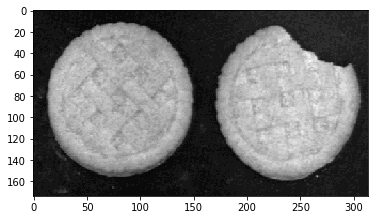

In [11]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
f = mpimg.imread('../figures/cookies.pgm')  
plt.imshow(f,cmap='gray')

#### Ex03.2
**Fernando:** Peguei a imagem astablet.tif para exercitar as transformações.

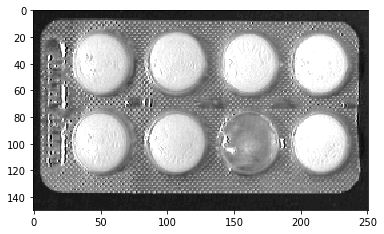

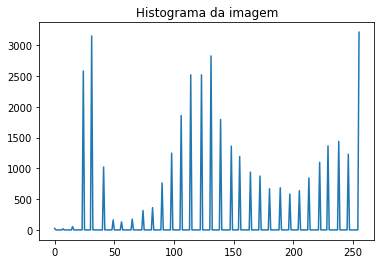

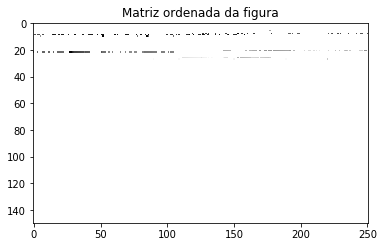

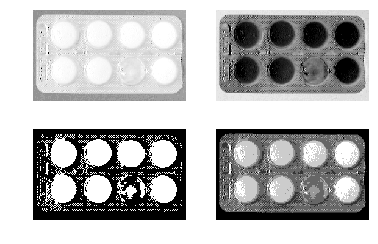

In [29]:
# Algumas transformações do tutorial
f_ex2 = normalize(mpimg.imread('../data/astablet.tif'))

T1_ex2 = np.arange(256).astype('uint8')
T2_ex2 = normalize(np.log(T1_ex2+1.))
T3_ex2 = 255 - T1_ex2
T4_ex2 = normalize(T1_ex2 > 150)
T5_ex2 = normalize(T1_ex2//50)

f2_ex2 = T2_ex2[f_ex2]
f3_ex2 = T3_ex2[f_ex2]
f4_ex2 = T4_ex2[f_ex2]
f5_ex2 = T5_ex2[f_ex2]

plt.imshow(f_ex2, cmap='gray', vmax=255)
plt.show()

h_ex2 = ia898_histogram(f_ex2)
plt.title('Histograma da imagem')
plt.plot(h_ex2)
plt.show()

sorted_f_flat = np.argsort(f_ex2.ravel())
sorted_f = sorted_f_flat.reshape(f_ex2.shape)

plt.imshow(sorted_f, cmap='gray', vmax=255)
plt.title('Matriz ordenada da figura')
plt.show()

plt.subplot(221).axis('off')
plt.imshow(f2_ex2, cmap='gray', vmax=255)

plt.subplot(222).axis('off')
plt.imshow(f3_ex2, cmap='gray', vmax=255)

plt.subplot(223).axis('off')
plt.imshow(f4_ex2, cmap='gray', vmax=255)

plt.subplot(224).axis('off')
plt.imshow(f5_ex2, cmap='gray', vmax=255)
plt.show()

#### Mosaico?

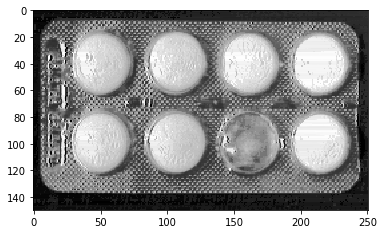

In [31]:
fsi = np.argsort(f_ex2.ravel())
gs = np.linspace(0,255,f_ex2.size).astype(np.uint8)
g = np.empty( (f_ex2.size,), np.uint8)
g[sorted_f_flat] = gs
plt.imshow(g.reshape(f_ex2.shape), cmap='gray')

In [ ]:
m_ex2 = np.linspace(0,255, f_ex2.size).astype('uint8')
m_ex2 = m_ex2.reshape(f_ex2.shape)

plt.imshow(m_ex2, cmap='gray')
plt.show()

m_eq_ex2 = np.empty((f_ex2.size), np.uint8)
m_eq_ex2[sorted_f] = m_ex2

plt.imshow(m_eq_ex2.reshape(f_ex2.shape), cmap='gray')
plt.show()

#### Ex03.3
**Fernando:**
Utilizei o exemplo _threshold_ do tutorial, com o _threshold_ 100 baseado no histograma da própria imagem (abaixo):
* Também tentei com outros thresholds, entre 50 e 80, mas ainda apareciam alguns artefatos na imagem resultante

In [ ]:
f_ex3 = mpimg.imread('../figures/cookies.pgm')  
h_cookie = ia898_histogram(f_ex3)
plt.plot(h_cookie)
plt.show()

In [ ]:
T = normalize((np.arange(256) > 100))

plt.plot(T)
plt.title('Threshold')
plt.show()

plt.imshow(T[f_ex3], cmap='gray')
plt.show()

h_cookie = ia898_histogram(f_ex3)

### Exercício 4
Você é capaz de transformar a imagem para identificar o número da placa do carro apresentado na imagem abaixo? 

In [ ]:
f = mpimg.imread('../figures/fusca.png')
plt.imshow(f,cmap='gray')

In [ ]:
print(f.shape)
print("Min: {} \t Max: {}".format(f.min(), f.max()))

In [ ]:
n = f.size
f_normalized = normalize(f)
h = ia898_histogram(f_normalized)

T = 255./n * np.cumsum(h)
f1 = T[f_normalized].astype('uint8')

T2 = normalize(np.log(np.arange(256).astype('uint8') + 1.))
f2 = T2[f_normalized]

plt.plot(h)

plt.subplot(121).axis('off')
plt.title('Equalizacao')
plt.imshow(f1, cmap='gray')


plt.subplot(122).axis('off')
plt.title('Funçao logaritmica')
plt.imshow(f2, cmap='gray')

plt.show()

h1 = ia898_histogram(f1)
h2 = ia898_histogram(f2)
plt.plot(h)
plt.title('Histograma da imagem original')
plt.show()

plt.plot(h1)
plt.title('Histograma equalizada')
plt.show()

plt.plot(h2)
plt.title('Histograma transformação logarítimca')
plt.show()

### Exercício 5
Escreva uma função que implemente a tranformação de brilho e contraste de uma imagem em níveis de cinza, baseada na construçao de três segmentos de retas:

- Primeiro segmento de reta: 'x' de '0' a 'x1', com angulo 'alpha';
- Segundo segmento de reta: 'x' de 'x1' a 'x2', com angulo 'beta';
- Terceiro segmento de reta: 'x' de 'x2' a '255';
- Retorno: mapeamento de brilho & contraste da 'imagem' de entrada.


In [ ]:
from PIL import Image
ang = Image.open('../figures/bc_angulos.png')
ang

Dicas:

- Determine *y1* e *y2* a partir de *alpha* e *beta*.
- Utilize a equação da reta, tendo dois pontos conhecidos *(xa,ya)* e *(xb,yb)*, para cada trecho de reta


#### Ex03.5:
Assumindo a equação da reta:

$y = ax + b$

Para determinar o coeficiente linear $b$ de cada segmento:

$-b = ax - y$

Também assumindo o coeficiente angular $a$:

$a=\Delta{x}/\Delta{y}$

Ou, com ângulo $\theta$ conhecido:

$a=tan(\theta)$

Para o problema apresentado:

$a_n=\frac{y_n-y_{n-1}}{x_n-x_{n-1}}=tan(\theta_n)$

Portanto:

$-b_n=a_nx_n-y_n$

In [ ]:
from math import tan

def transform(x1y1=(20, 100), x2y2=(100,200), x3y3=(255,255), res=256):
    # Assumindo valores padrão, caso não sejam informados
    T = np.arange(res).astype('uint8')
    x1, y1 = x1y1
    x2, y2 = x2y2
    x3, y3 = x3y3
    
    if not (x1 == x2):
        if x1 == 0:
            a1 = 1
        else:
            a1 = (y1/x1)
        a2 = (y2-y1)/(x2-x1)
        a3 = (y3-y2)/(x3-x2)
        
        b1 = 0
        b2 = -((a2*x2)-y2)
        b3 = -((a3*x3)-y3)

        T1 = a1*T[:x1:]
        T2 = a2*T[x1:x2:] + b2
        T3 = a3*T[x2::] + b3
        Tfinal=np.concatenate((T1,T2,T3))
        
    if (x1 == x2):
        T[:x1:] = y1
        T[x1::] = y2
        Tfinal = T
    
    return Tfinal


#### Função utilizando ângulo e x
* O ângulo de y2 deve ser em relação ao coeficiente linear de y2, que é desconhecido. Felizmente, temos o valor de (x1, y1). Se traçarmos uma reta paralela ao eixo x, que passa em (x1, y1), podemos deslocar a origem do ângulo de y2 até essa reta, que é um ângulo correspondente ao de y2.


In [ ]:
def transform_angle(x1, angle1, x2, angle2):
    a1 = tan(angle1)
    a2 = tan(angle2)
    y1 = a1*x1
    y2 = (a2*x2) + y1
    print((y1,y2))
    x1y1 = (x1, y1)
    x2y2 = (x2, y2)
    return transform(x1y1, x2y2)

In [ ]:
from math import pi
xaya = (90, 50)
xbyb = (150, 150)
Tfinal1 = transform(xaya,xbyb)

xaya = (10, 100)
xbyb = (100, 200)
Tfinal2 = transform(xaya, xbyb)

xaya = (128, 0)
xbyb = (128, 255)
Tfinal3 = transform(xaya, xbyb)

xa = 30
alpha = ((4*pi)/9) # 80 graus
xb = 100
beta = (pi/9) # 20 graus
Tfinal4 = transform_angle(xa, alpha, xb, beta)

normalized_f = normalize(f, [0,255])
ffinal1=Tfinal1[normalized_f]
plt.subplot(121).axis('off')
plt.title('T1')
plt.imshow(ffinal1, cmap='gray', vmax=255)

plt.subplot(122).axis('off')
ffinal2=Tfinal2[normalized_f]
plt.imshow(ffinal2, cmap='gray', vmax=255)
plt.title('T2')

plt.show()

plt.subplot(121).axis('off')
ffinal3=Tfinal3[normalized_f]
plt.imshow(ffinal3, cmap='gray', vmax=255)
plt.title('T3')

plt.subplot(122).axis('off')
ffinal4=Tfinal4[normalized_f]
plt.imshow(ffinal4, cmap='gray', vmax=255)
plt.title('T4 (Com ângulos)')

plt.show()

plt.plot(Tfinal1)
plt.plot(Tfinal2)
plt.plot(Tfinal3)
plt.plot(Tfinal4)
plt.legend(['T1', 'T2', 'T3', 'T4 (Com ângulos)'], loc='right')
plt.show()